In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from datetime import timedelta
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm

import plotly.express as px
import plotly.graph_objects as go

In [320]:
def get_cpi():
    cpi = pd.read_excel('data/CPIAUCSL (1).xls')
    #cpi = pd.read_csv("T5YIE.csv")
    cpi.columns = ["date", 'CPI']
    cpi["date"] = pd.to_datetime(cpi["date"]) - timedelta(days=1)
    return cpi

def get_stocks():
    stocks = pd.read_csv("data/stocks.csv")
    stocks["MthCalDt"] = pd.to_datetime(stocks["MthCalDt"])
    return stocks


def merge_cpi_stock(stocks, cpi):
    merged = pd.merge(stocks, cpi, how="left", left_on="MthCalDt", right_on="date")
    return merged

In [321]:
# get factors
def get_factors():

    ff_factors = pd.read_csv("data/ff_factors.csv")
    ff_factor_mom = pd.read_csv("data/ff_factor_umd.csv")
    ff_factors.rename({"Unnamed: 0": "date"}, axis=1, inplace=True)
    ff_factor_mom.rename({"Unnamed: 0": "date", "Mom":"UMD"}, axis=1, inplace=True)
    ff_factor_mom.rename({"Unnamed: 0": "date", "Mom   ":"UMD"}, axis=1, inplace=True)
    ff_factors = ff_factors.merge(ff_factor_mom, how="left", on="date")
    
    ff_factors["date"] = pd.to_datetime(ff_factors["date"], format="%Y%m")
    ff_factors["date"] += MonthEnd(0)


    return ff_factors

In [322]:
def bin_inflation_regimes(merged):
    merged["Inflation"] = pd.cut(merged["CPI"],[-1, 0,.2,.4,5], labels=["deflation","low", "mid", "high"])
    return merged

In [323]:
def get_company(merged, permno):
    comp = merged[merged["PERMNO"] == permno][["MthCalDt","MthRet"]]
    comp = comp.drop_duplicates(subset="MthCalDt", keep="first")
    comp = comp.set_index("MthCalDt")
    comp.index = comp.index + MonthEnd(0)

    return comp

In [324]:
def prep_reg(ff_factors, comp, remove_factors = []):
    removed_cols = ["RF"] + remove_factors
    X = ff_factors[[x for x in ff_factors.columns if not x in removed_cols]].set_index("date")
    comp["Excess Return"] = comp["MthRet"] - ff_factors.set_index("date")["RF"]
    y = comp['Excess Return']

    # get indies that are the same between X and y
    indies_X = X.index.intersection(y.index)

    indies_y = y.index.intersection(X.index)

    indies = indies_X.intersection(indies_y)

    # save those rows
    X = X.loc[indies]
    y = y.loc[indies]
    
    y = y * 100
    
    return X, y

In [325]:
def run_reg(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    results.summary()
    return results.params[1:]

In [312]:
# get only 2022 data for cpi
cpi[cpi["date"] > "2021-12-31"]

,date,CPI_Percent_Change
900,2022-01-31,0.79771
901,2022-02-28,1.24075
902,2022-03-31,0.33193
903,2022-04-30,0.97380
904,2022-05-31,1.32224
905,2022-06-30,-0.01930
906,2022-07-31,0.11820
907,2022-08-31,0.38597
908,2022-09-30,0.43840
909,2022-10-31,0.09629


In [313]:
cpi = get_cpi()
stocks = get_stocks()
merged = merge_cpi_stock(stocks, cpi)
merged = bin_inflation_regimes(merged)
ff_factors = get_factors()


/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_35431/3555157619.py:9: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [314]:
cpi

,date,CPI_Percent_Change
0,1947-01-31,0.65177
1,1947-02-28,1.75763
2,1947-03-31,0.00000
3,1947-04-30,-0.22727
4,1947-05-31,0.59226
...,...,...
906,2022-07-31,0.11820
907,2022-08-31,0.38597
908,2022-09-30,0.43840
909,2022-10-31,0.09629


In [169]:
from tqdm import tqdm

In [185]:
# for each perno, get the excess return and run a regression
# save the betas
beta_dict = {}
for permno in tqdm(merged["PERMNO"].unique()):
    # supress warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        try:
            comp = get_company(merged, permno)
            if len(comp) < 12:
                continue
            X, y = prep_reg(ff_factors, comp)
            
            if (X.shape[0] < 2) or (y.shape[0] < 2):
                continue
            
            beta_dict[permno] = run_reg(X, y).values
        except ValueError:
            print("ValueError for permno: ", permno)
            break

100%|██████████| 36144/36144 [08:00<00:00, 75.20it/s] 


In [186]:
betas = pd.DataFrame(beta_dict).T
betas.columns = X.columns

In [188]:
betas.reset_index(inplace=True)

In [190]:
betas.rename({"index": "PERMNO"}, axis=1, inplace=True)

In [191]:
betas

,PERMNO,Mkt-RF,SMB,HML,RMW,CMA,UMD
0,10000,-0.756132,4.886128,2.610467,-4.477707,-6.509955,2.379360
1,10001,-0.075395,0.755356,0.056853,-0.232516,-0.337785,-0.559832
2,10002,0.122566,1.525182,1.142493,0.362636,-0.274842,-0.423107
3,10003,1.495267,5.543331,6.463190,0.181900,-1.655064,-0.263197
4,10005,1.327231,1.341277,-4.967922,-2.374611,8.207193,-3.695720
...,...,...,...,...,...,...,...
33488,93432,-0.589409,-6.024435,-4.946234,-11.587453,2.367807,5.060635
33489,93433,1.468938,-8.192412,2.555918,-1.553371,-9.722839,-8.709984
33490,93434,0.510665,0.281969,0.925659,-0.328132,-1.017246,-0.014302
33491,93435,2.138985,-0.872100,7.780030,-2.168000,-12.013305,0.983280


In [218]:
betas = betas.dropna()

In [219]:
merged_factors = pd.merge(merged, betas, how="inner", on="PERMNO")

In [222]:
merged_factors.isna().sum()

PERMNO                      0
PrimaryExch                 0
SecurityNm                  0
Ticker                   6067
SICCD                       0
ICBIndustry                 0
MthCalDt                    0
MthPrc                    212
MthRet                    241
MthVol                 247495
ShrOut                  25372
date                  1204826
CPI_Percent_Change    1204826
Inflation             1211016
Mkt-RF                      0
SMB                         0
HML                         0
RMW                         0
CMA                         0
UMD                         0
dtype: int64

In [308]:
merged.groupby("Inflation")["MthCalDt"].nunique()

Inflation
deflation     99
low          163
mid          187
high         185
Name: MthCalDt, dtype: int64

In [231]:
# create 4 dataframes, one for each inflation regime
deflated = merged_factors[merged_factors["Inflation"] == "deflation"].copy().dropna(subset=["MthRet"])
low = merged_factors[merged_factors["Inflation"] == "low"].copy().dropna(subset=["MthRet"])
mid = merged_factors[merged_factors["Inflation"] == "mid"].copy().dropna(subset=["MthRet"])
high = merged_factors[merged_factors["Inflation"] == "high"].copy().dropna(subset=["MthRet"])

{deflation: {mkt-rf: (x, y)} }

In [266]:
X_factors = ["Mkt-RF","SMB","HML","RMW","CMA","UMD"]
y_returns = ["MthRet"]

regimes_names = ["deflated", "low", "mid", "high"]

regimes = [deflated, low, mid, high]

regime_betas = {}

for regime_i in range(len(regimes)):
    regime = regimes[regime_i]
    regime_name = regimes_names[regime_i]
    factor_betas = {}
    X = regime[X_factors]
    y = regime[y_returns]
    
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    results.summary()
    
    for factor in X_factors:
        regime_betas[(regime_name, factor)] = (results.params[factor], results.tvalues[factor])
    


In [269]:
# dict to pandas dataframe multiindex
regime_df = pd.DataFrame(regime_betas).T
regime_df.columns = ["beta", "t-stat"]

In [278]:
regime_df

beta     t-stat
deflated Mkt-RF  0.003302   8.844073
         SMB     0.004676  17.985950
         HML     0.001550   6.469171
         RMW    -0.001068  -5.618243
         CMA     0.001689   8.323133
         UMD     0.000394   1.209929
low      Mkt-RF  0.004143  16.485013
         SMB     0.000666   3.924659
         HML    -0.000922  -5.990428
         RMW     0.000512   4.432580
         CMA    -0.002402 -18.728996
         UMD     0.001789   8.365550
mid      Mkt-RF  0.005817  22.937428
         SMB    -0.000317  -1.944513
         HML    -0.003178 -22.224008
         RMW     0.000825   7.458045
         CMA    -0.004117 -34.559373
         UMD    -0.001936  -8.875877
high     Mkt-RF  0.002344   9.365042
         SMB     0.001524   9.723448
         HML    -0.002030 -14.016178
         RMW    -0.000856  -7.472756
         CMA     0.000564   4.974764
         UMD     0.002841  13.154169

<AxesSubplot:>

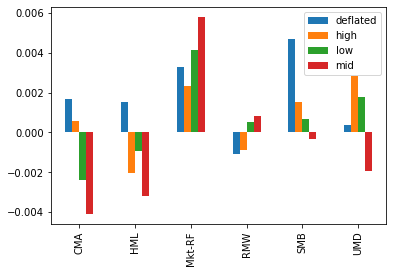

In [277]:
regime_df.unstack(level=0)['beta'].plot(
    kind='bar'
)

In [280]:
regime_df.index

MultiIndex([('deflated', 'Mkt-RF'),
            ('deflated',    'SMB'),
            ('deflated',    'HML'),
            ('deflated',    'RMW'),
            ('deflated',    'CMA'),
            ('deflated',    'UMD'),
            (     'low', 'Mkt-RF'),
            (     'low',    'SMB'),
            (     'low',    'HML'),
            (     'low',    'RMW'),
            (     'low',    'CMA'),
            (     'low',    'UMD'),
            (     'mid', 'Mkt-RF'),
            (     'mid',    'SMB'),
            (     'mid',    'HML'),
            (     'mid',    'RMW'),
            (     'mid',    'CMA'),
            (     'mid',    'UMD'),
            (    'high', 'Mkt-RF'),
            (    'high',    'SMB'),
            (    'high',    'HML'),
            (    'high',    'RMW'),
            (    'high',    'CMA'),
            (    'high',    'UMD')],
           )

In [293]:
regime_df_non_multi = regime_df.reset_index().rename({"level_0": "regime", "level_1": "factor"}, axis=1)

In [294]:
regime_df_non_multi

,regime,factor,beta,t-stat
0,deflated,Mkt-RF,0.003302,8.844073
1,deflated,SMB,0.004676,17.985950
2,deflated,HML,0.001550,6.469171
3,deflated,RMW,-0.001068,-5.618243
4,deflated,CMA,0.001689,8.323133
5,deflated,UMD,0.000394,1.209929
6,low,Mkt-RF,0.004143,16.485013
7,low,SMB,0.000666,3.924659
8,low,HML,-0.000922,-5.990428
9,low,RMW,0.000512,4.432580


In [297]:
regime_df_non_multi["beta"]

0     0.003302
1     0.004676
2     0.001550
3    -0.001068
4     0.001689
5     0.000394
6     0.004143
7     0.000666
8    -0.000922
9     0.000512
10   -0.002402
11    0.001789
12    0.005817
13   -0.000317
14   -0.003178
15    0.000825
16   -0.004117
17   -0.001936
18    0.002344
19    0.001524
20   -0.002030
21   -0.000856
22    0.000564
23    0.002841
Name: beta, dtype: float64

In [298]:
regime_df_non_multi

,regime,factor,beta,t-stat
0,deflated,Mkt-RF,0.003302,8.844073
1,deflated,SMB,0.004676,17.985950
2,deflated,HML,0.001550,6.469171
3,deflated,RMW,-0.001068,-5.618243
4,deflated,CMA,0.001689,8.323133
5,deflated,UMD,0.000394,1.209929
6,low,Mkt-RF,0.004143,16.485013
7,low,SMB,0.000666,3.924659
8,low,HML,-0.000922,-5.990428
9,low,RMW,0.000512,4.432580


In [305]:
# plot the betas using plotly plot grouped by factor and regime
# make plot bigger

import plotly.express as px

fig = px.bar(regime_df_non_multi, x="factor", y="beta", color="regime", barmode="group")
fig.show()

In [ ]:
# data cleaning
# verfiy results
# rerun traditional model with lookahead


<AxesSubplot:>

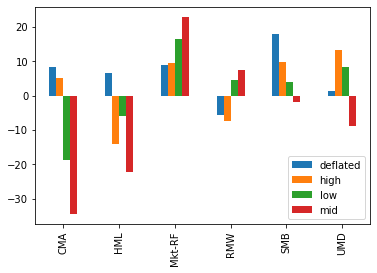

In [279]:
regime_df.unstack(level=0)['t-stat'].plot(
    kind='bar'
)